
__Equação SARIMA__\
Uma equação típica do modelo SARIMA se parece com o seguinte –

$SARIMA(p,d,q)\times(P,D,Q)_{lag}$

Os parâmetros para esses tipos de modelos são os seguintes:

__p__ e sazonal __P__: indicam o número de termos AR (defasagens da série estacionária)\
__d__ e sazonal __D__: indicam diferenciações que devem ser feitas para as séries tornarem-se estacionárias\
__q__ e __Q__ sazonal: indicam o número de termos MA (lags dos erros da previsão)\
__lag__: indica o intervalo da sazonalidade nos dados

__Fazendo com que uma série temporal torne-se estacionária__

Uma série temporal estacionária é aquela que não possui nenhuma tendência ou sazonalidade. É essencial lidar com qualquer tendência ou sazonalidade antes de modelar os dados da série temporal porque se as propriedades estatísticas não mudarem ao longo do tempo, torna-se mais fácil modelar os dados com precisão. Uma das maneiras populares de se fazer com que a série torne-se estacionária é __diferenciando__.

__Modelagem SARIMA__


Plote a série - para verificar se há discrepâncias\
Transforme os dados (para tornar a média e a variância constantes)\
Aplique testes estatísticos para verificar se a série é estacionária (tanto de tendência quanto de sazonalidade)\
Se não estacionário (ou seja, se possui tendência ou sazonalidade), torne-a estacionária diferenciando\
Plote ACF de séries estacionárias para ordem MA, ordem MA sazonal em picos sazonais\
Traçar PACF de séries estacionárias para ordem AR, ordem AR sazonal em picos sazonais\
Execute SARIMA com esses parâmetros\
Verifique a validade do modelo usando gráficos de resíduos

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from joblib import Parallel # Processamento paralelo
from multiprocessing import cpu_count
from joblib import delayed

In [2]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [3]:
#define function for kpss test
from statsmodels.tsa.stattools import kpss
#define KPSS
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
      kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [4]:
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

#### Carregando os dados pré-processados para o modelo

In [5]:
filepath = "..\data\processed\CATEG_1.csv"
df = pd.read_csv(filepath).sort_values(by = ["DATE"])
df.head(3)

,DATE,UNITS_SOLD
510,2018-10-16,1
164,2019-06-11,27
514,2019-06-12,26


In [6]:
df = df[df["DATE"] > "2018-10-16"]
df['DATE'] = pd.to_datetime(df['DATE'])
df['UNITS_SOLD'] = df['UNITS_SOLD'].astype(float)
df.head(3)

,DATE,UNITS_SOLD
164,2019-06-11,27.0
514,2019-06-12,26.0
128,2019-06-13,24.0


In [7]:
df['UNITS_SOLD'].min(), df['UNITS_SOLD'].max()

(8.0, 210.0)

In [8]:
df['DATE'].min(), df['DATE'].max()

(Timestamp('2019-06-11 00:00:00'), Timestamp('2021-11-12 00:00:00'))

In [9]:
df.isnull().sum()
df = df.dropna()
df.isnull().sum()

DATE          0
UNITS_SOLD    0
dtype: int64

In [10]:
df = df.set_index('DATE')

In [11]:
# ts_month_avg = df

#### Será definida uma reamostragem com medias semanais para a análise. Pois será mais expressiva a métrica de sazonalidade a seguir.

[dataframe.resample](https://www.geeksforgeeks.org/python-pandas-dataframe-resample/)

In [12]:
# reamostragem pela média semanal
ts_month_avg = df['UNITS_SOLD'].resample('15D').mean()
ts_month_avg = ts_month_avg.dropna()

In [13]:
len(ts_month_avg)


60

In [14]:
L = len(ts_month_avg)
train_df = ts_month_avg[0:int(L*0.80)]
test_df = ts_month_avg[int(L*0.80):int(L*0.90)]
validation_df = ts_month_avg[int(L*0.90):]

In [15]:
len(train_df) + len(test_df) + len(validation_df)

60

__Gráfico dos dados__

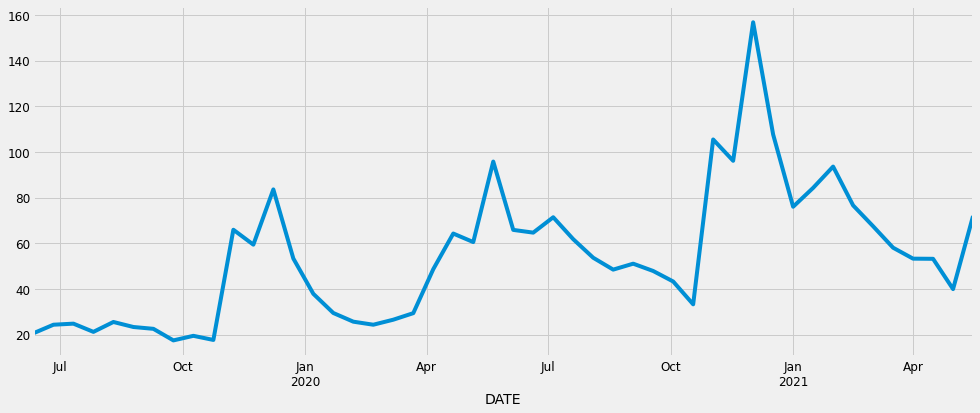

In [16]:
train_df.plot(figsize=(15, 6))
plt.show()


__Identificando Variação, Tendência e Sazonalidade nos dados__\
Vamos verificar a tendência e os componentes sazonais dos dados. Cada série temporal pode ser decomposta em 3 componentes

Tendência\
Sazonalidade\
Ruído

Vamos ver nossa série temporal decomposta –

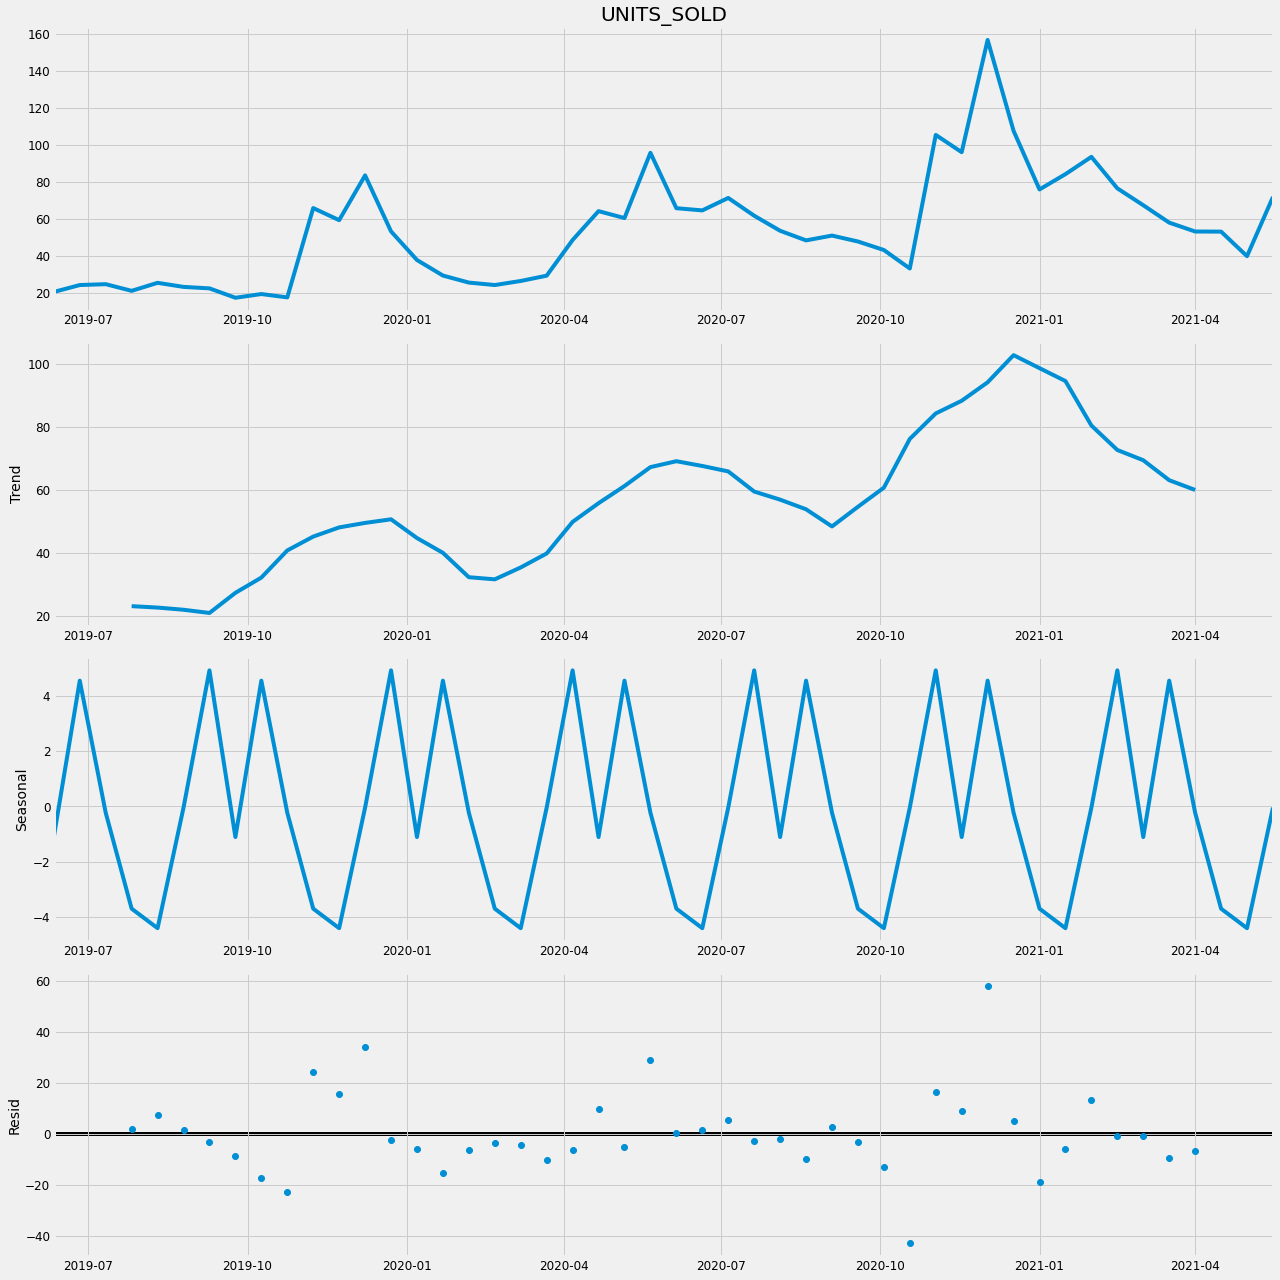

In [17]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 18
decomposition = sm.tsa.seasonal_decompose(train_df, model='additive')
fig = decomposition.plot()
plt.show()

Como podemos ver, há uma tendência de alta e uma sazonalidade semestral (6 x 4 semans por mês implica um lag = 24) nos dados. Portanto, a série não é estacionária. Temos que lidar com a sazonalidade analisar o efeito. Será realizada a diferenciação e será verificado o resultado por testes estatísticos como ADF (para tendência) e OSCB (para sazonalidade).

Regra de polegar para testes estatísticos -
ADF(para tendência): se o valor p for menor que o valor crítico, a série é estacionária
OSCB(para sazonalidade): se o valor for menor que 0,64, a série é estacionária

In [18]:
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# plot_acf(ts_month_avg, lags=24)
# matplotlib.pyplot.show()

# plot_pacf(ts_month_avg, lags=24)
# matplotlib.pyplot.show()

# from pylab import rcParams
# rcParams['figure.figsize'] = 18, 8
# decomposition = sm.tsa.seasonal_decompose(ts_month_avg, model='additive')
# fig = decomposition.plot()
# plt.show()

In [19]:
#apply adf test on the series
print(adf_test(train_df))
# print(kpss_test(ts_month_avg))

Results of Dickey-Fuller Test:
Test Statistic                 -2.755787
p-value                         0.064872
#Lags Used                      0.000000
Number of Observations Used    47.000000
Critical Value (1%)            -3.577848
Critical Value (5%)            -2.925338
Critical Value (10%)           -2.600774
dtype: float64
None


Depois de executar o teste ADF na série temporal, obtemos  __p__ = __0.112672__ que é maior que o valor crítico de 0,05. Assim podemos confirmar estatisticamente que a série não é estacionária. Portanto, podemos realizar uma diferenciação de primeira ordem para a tendência e executamos novamente o teste ADF para verificar a estacionariedade.

<AxesSubplot:xlabel='DATE'>

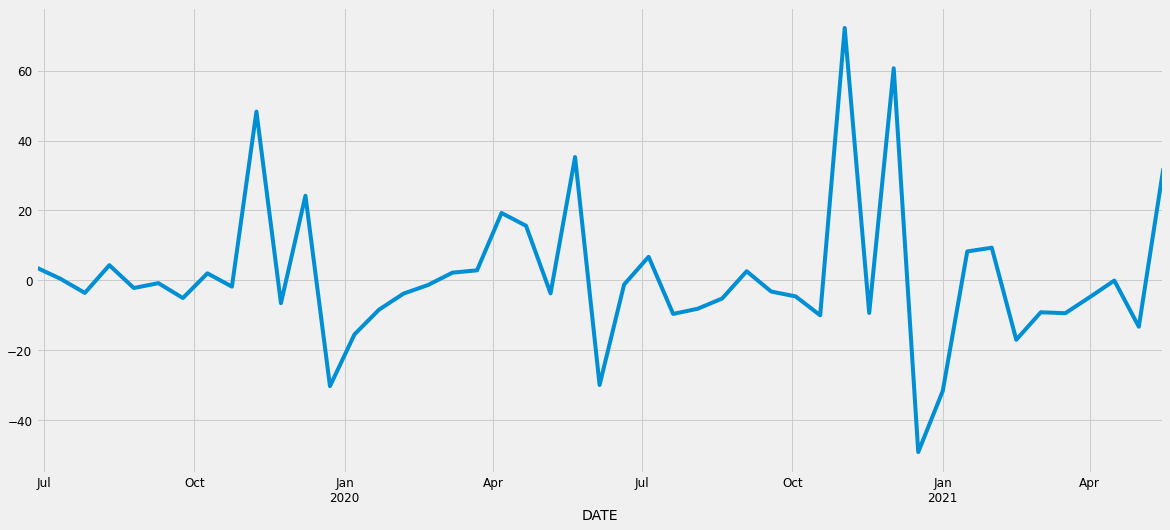

In [20]:
rcParams['figure.figsize'] = 18, 8
ts_t_adj = train_df - train_df.shift(1)
ts_t_adj = ts_t_adj.dropna()
ts_t_adj.plot()

In [21]:
#apply adf test on the series
print(adf_test(ts_t_adj))

Results of Dickey-Fuller Test:
Test Statistic                -8.434980e+00
p-value                        1.826993e-13
#Lags Used                     0.000000e+00
Number of Observations Used    4.600000e+01
Critical Value (1%)           -3.581258e+00
Critical Value (5%)           -2.926785e+00
Critical Value (10%)          -2.601541e+00
dtype: float64
None


Observando o __p-value__ a __tendência__ agora parece ter desaparecido. O valor p é menor que o valor crítico de 0,05. Portanto, podemos confirmar que a série agora é uma tendência estacionária.

Passemos agora para a diferenciação __sazonal__. Como os dados estão mostrando uma sazonalidade semestral, realizaremos uma diferenciação com defasagem 15 dias => 12 lags.

<AxesSubplot:xlabel='DATE'>

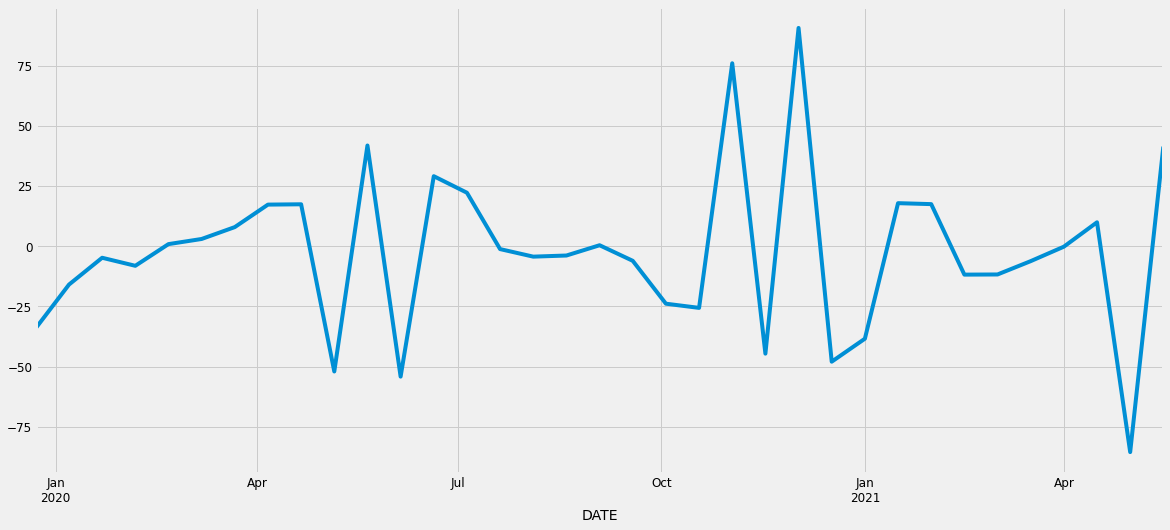

In [22]:
ts_s_adj = ts_t_adj - ts_t_adj.shift(12)
ts_s_adj = ts_s_adj.dropna()
ts_s_adj.plot()

Agora que os dados estão estacionários, vamos para a próxima etapa do processo – os gráficos ACF e PACF.

Parcelas ACF e PACF

Vamos tentar descobrir os parâmetos do modelo 

Para descobrir isso , precisaríamos traçar os gráficos ACF e PACF.

ACF significa Função de Correlação Automática e PACF significa Função de Correlação Automática Parcial.

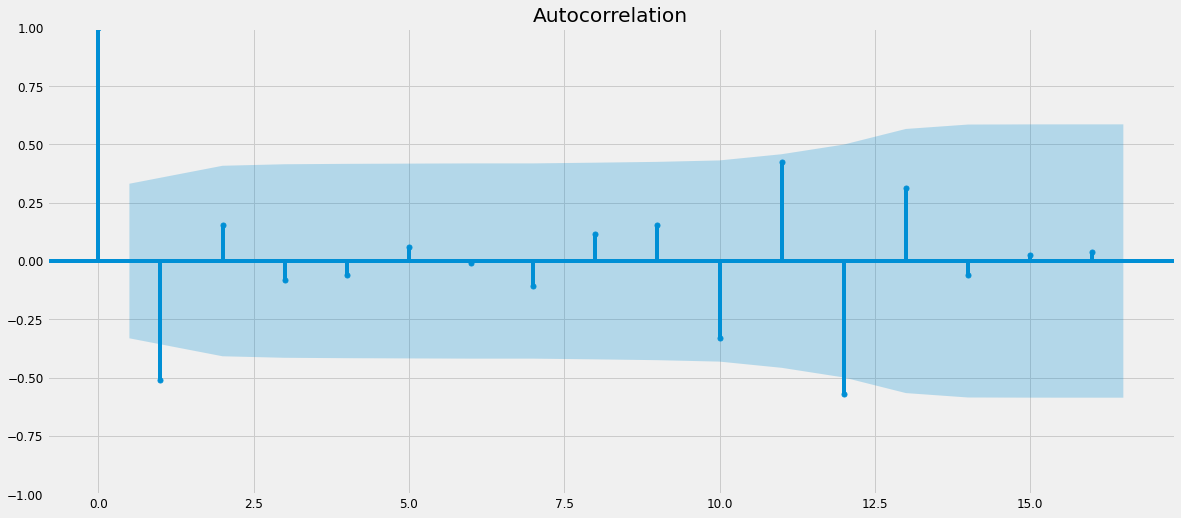

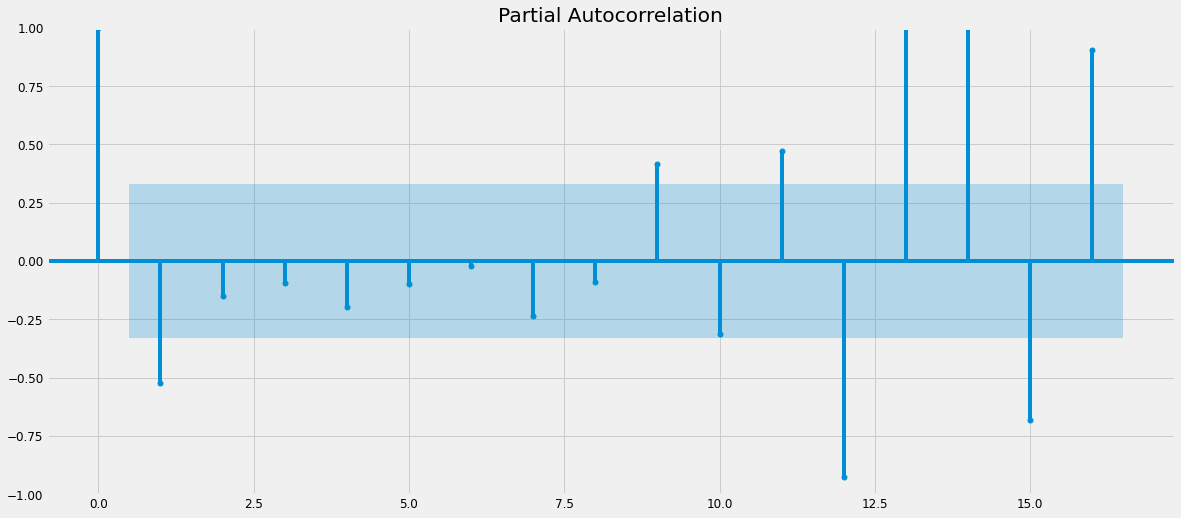

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts_s_adj)
matplotlib.pyplot.show()
plot_pacf(ts_s_adj)
matplotlib.pyplot.show()

$SARIMA(p,d,q)\times(P,D,Q)_{lag}$

Os parâmetros para esses tipos de modelos são os seguintes:

__p__ e sazonal __P__: indicam o número de termos AR (defasagens da série estacionária)\
__d__ e sazonal __D__: indicam diferenciações que devem ser feitas para as séries tornarem-se estacionárias\
__q__ e __Q__ sazonal: indicam o número de termos MA (lags dos erros da previsão)\
__lag__: indica o intervalo da sazonalidade nos dados

__Estimando termos de AR, ou p__

O gráfico de pirulito que você vê acima são os resultados do ACF e do PACF. Para estimar a quantidade de termos AR, você precisa olhar para o gráfico PACF. Primeiro, ignore o valor na defasagem 0. Ele sempre mostrará uma correlação perfeita, pois estamos estimando a correlação entre o valor de hoje consigo mesmo. Observe que há uma área azul no gráfico, representando o intervalo de confiança. Para estimar quantos termos de AR você deve usar, comece a contar quantos “pirulito” estão acima ou abaixo do intervalo de confiança antes que o próximo entre na área azul.

p = 0


__Estimativa de termos I, ou d__

Esta é uma parte fácil. Tudo o que você precisa fazer para estimar a quantidade de I(d) termos é saber quantas diferenciações foram usadas para tornar a série estacionária. Por exemplo, se você usou diferença logarítmica ou primeira diferença para transformar uma série temporal, a quantidade de termos I será 1, pois Arauto toma a diferença entre o valor real (por exemplo, o valor de hoje) e 1 valor anterior (por exemplo, o valor de ontem).

d = 1

__Estimando termos de MA, ou q__

Assim como a função PACF, para estimar a quantidade de termos MA, desta vez você observará o gráfico ACF. A mesma lógica é aplicada aqui: quantos pirulitos estão acima ou abaixo do intervalo de confiança antes que o próximo pirulito entre na área azul?

q = 0

__Estimando termos sazonais de RA, ou P__
Caso seus dados possuam sazonalidade e você queira utilizar um modelo Sazonal ARIMA, é necessário informar os termos sazonais para AR, I e MA. O processo é bastante semelhante ao AR não sazonal, e você ainda usará a função ACF e PACF para isso. Para estimar a quantidade de termos AR, você examinará mais uma vez a função PACF. Agora, em vez de contar quantos pirulitos estão fora do intervalo de confiança, você contará quantos pirulitos sazonais estão fora.

Como os dados possuem sazonalidade semestral, é preciso verificar se o “pirulito” na defasagem 6 está fora da área do intervalo de confiança. Em caso de resultado positivo, é necessário adicionar 1 termo para AR Sazonal. Como temos um pirulito negativo na posição 6 adicionamos 1.

P = 0

__Estimating Seasonal I terms__

A mesma lógica de estimar a diferenciação não sazonal é aplicada aqui. Se você usou a diferenciação sazonal para tornar a série temporal estacionária (por exemplo, o valor real (Yt) subtraído por 12 meses anteriores (Yt-12)), você adicionará 1 termo à diferenciação sazonal.

D = 1

__Estimating Seasonal MA terms__

Para a média móvel sazonal (SMA), estaremos olhando para o gráfico ACF e usaremos a mesma lógica de estimar os termos SAR.
Como só temos uma correlação forte em 4 temos, estimamos que o valor deve ser 0 ou 1.

Q = 1

lag = 18

Portanto,

$SARIMA(p,d,q)\times(P,D,Q)_{lag}$
$SARIMA(0,1,0)\times(1,1,1)_{26}$


In [24]:
p = range(0, 6)
d = range(0, 6)
q = range(0, 6)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = []
for x in list(itertools.product(p, d, q)):
    seasonal_pdq.append((x[0], x[1], x[2], 12) )

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
seasonal_pdq

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 0, 3, 12)


[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 0, 2, 12),
 (0, 0, 3, 12),
 (0, 0, 4, 12),
 (0, 0, 5, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (0, 1, 2, 12),
 (0, 1, 3, 12),
 (0, 1, 4, 12),
 (0, 1, 5, 12),
 (0, 2, 0, 12),
 (0, 2, 1, 12),
 (0, 2, 2, 12),
 (0, 2, 3, 12),
 (0, 2, 4, 12),
 (0, 2, 5, 12),
 (0, 3, 0, 12),
 (0, 3, 1, 12),
 (0, 3, 2, 12),
 (0, 3, 3, 12),
 (0, 3, 4, 12),
 (0, 3, 5, 12),
 (0, 4, 0, 12),
 (0, 4, 1, 12),
 (0, 4, 2, 12),
 (0, 4, 3, 12),
 (0, 4, 4, 12),
 (0, 4, 5, 12),
 (0, 5, 0, 12),
 (0, 5, 1, 12),
 (0, 5, 2, 12),
 (0, 5, 3, 12),
 (0, 5, 4, 12),
 (0, 5, 5, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 0, 2, 12),
 (1, 0, 3, 12),
 (1, 0, 4, 12),
 (1, 0, 5, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12),
 (1, 1, 2, 12),
 (1, 1, 3, 12),
 (1, 1, 4, 12),
 (1, 1, 5, 12),
 (1, 2, 0, 12),
 (1, 2, 1, 12),
 (1, 2, 2, 12),
 (1, 2, 3, 12),
 (1, 2, 4, 12),
 (1, 2, 5, 12),
 (1, 3, 0, 12),
 (1, 3, 1, 12),
 (1, 3, 2, 12),
 (1, 3, 3, 12),
 (1, 3, 4, 12),
 (1, 3, 5, 12),
 (1, 4, 0, 12),
 (1, 4, 1, 12),
 (1, 4, 

In [25]:
# executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')

# scores = executor(tasks)

In [26]:
# Parelização de processamento. Infelizmento está travando o pc. Provavelmente devido aso problemas do windows 11 e ao pc dell.
# from operator import itemgetter
# params_list = []
# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(train_df,
#                                             order=param,
#                                             seasonal_order=param_seasonal,
#                                             )
#             results = mod.fit(method = 'powell')
#             executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
#             tasks = (delayed(results)(train_df, test_df, cfg) for cfg in param_seasonal)
#             scores = executor(tasks)
#             print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, scores.aic))
#             params_list.append([param, param_seasonal, scores.aic])
#         except:
#             continue

# params_list = sorted(params_list, key=itemgetter(2))[0]
# print(f'Best SARIMA params: {params_list[0]}x{params_list[1]}12 - AIC:{params_list[2]}')

In [27]:
from operator import itemgetter
params_list = []
params_list_top = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_df,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            )
            results = mod.fit(method = 'powell')
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            params_list.append([param, param_seasonal, results.aic])
            params_list_sort = []
            params_list_sort = sorted(params_list, key=itemgetter(2))
            params_list_sort_1 = params_list_sort[0]
            params_list_sort_2 = params_list_sort[2]
            params_list_sort_3 = params_list_sort[3]
            params_list_sort_4 = params_list_sort[4]
            params_list_sort_5 = params_list_sort[5]
            print(f'TOP 1 SARIMA params: {params_list_sort_1[0]}x{params_list_sort_1[1]}12 - AIC:{params_list_sort_1[2]}')
            print(f'TOP 2 SARIMA params: {params_list_sort_2[0]}x{params_list_sort_2[1]}12 - AIC:{params_list_sort_2[2]}')
            print(f'TOP 3 SARIMA params: {params_list_sort_3[0]}x{params_list_sort_3[1]}12 - AIC:{params_list_sort_3[2]}')
            print(f'TOP 4 SARIMA params: {params_list_sort_4[0]}x{params_list_sort_4[1]}12 - AIC:{params_list_sort_4[2]}')
            print(f'TOP 5 SARIMA params: {params_list_sort_5[0]}x{params_list_sort_5[1]}12 - AIC:{params_list_sort_5[2]}')
        except:
            continue

params_list_sort = []
params_list_sort = sorted(params_list, key=itemgetter(2))[0]
print(f'Best SARIMA params: {params_list_sort[0]}x{params_list_sort[1]}12 - AIC:{params_list_sort[2]}')

Optimization terminated successfully.
         Current function value: 5.538958
         Iterations: 1
         Function evaluations: 26
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:533.7400069410955
Optimization terminated successfully.
         Current function value: 5.285599
         Iterations: 4
         Function evaluations: 98
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:511.4174974286549
Optimization terminated successfully.
         Current function value: 5.240345
         Iterations: 4
         Function evaluations: 220
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:509.0731297680612
Optimization terminated successfully.
         Current function value: 5.058272
         Iterations: 6
         Function evaluations: 355
ARIMA(0, 0, 0)x(0, 0, 3, 12)12 - AIC:493.5941015957814
Optimization terminated successfully.
         Current function value: 5.065188
         Iterations: 5
         Function evaluations: 384
ARIMA(0, 0, 0)x(0, 0, 4, 12)12 - AIC:496.25808453142383
Optimization terminated successfully

c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 37
ARIMA(0, 0, 0)x(1, 4, 1, 12)12 - AIC:6.0
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(0, 4, 2, 12)12 - AIC:6.0
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 49
ARIMA(0, 0, 0)x(1, 4, 2, 12)12 - AIC:8.0
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(0, 4, 2, 12)12 - AIC:6.0
Optimization terminated successfully.
         Current function value: -

c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 37
ARIMA(0, 0, 0)x(1, 5, 1, 12)12 - AIC:6.0
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 49
ARIMA(0, 0, 0)x(1, 5, 2, 12)12 - AIC:8.0
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value: -

c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 49
ARIMA(0, 0, 0)x(2, 4, 1, 12)12 - AIC:8.0
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 61
ARIMA(0, 0, 0)x(2, 4, 2, 12)12 - AIC:10.0
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value: 

c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 49
ARIMA(0, 0, 0)x(2, 5, 1, 12)12 - AIC:8.0
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 61
ARIMA(0, 0, 0)x(2, 5, 2, 12)12 - AIC:10.0
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value: 

c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 61
ARIMA(0, 0, 0)x(3, 4, 1, 12)12 - AIC:10.0
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 73
ARIMA(0, 0, 0)x(3, 4, 2, 12)12 - AIC:12.0
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value:

c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 61
ARIMA(0, 0, 0)x(3, 5, 1, 12)12 - AIC:10.0
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 73
ARIMA(0, 0, 0)x(3, 5, 2, 12)12 - AIC:12.0
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value:

c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 73
ARIMA(0, 0, 0)x(4, 4, 1, 12)12 - AIC:12.0
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 85
ARIMA(0, 0, 0)x(4, 4, 2, 12)12 - AIC:14.0
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value:

c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 0)x(4, 5, 0, 12)12 - AIC:10.0
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 73
ARIMA(0, 0, 0)x(4, 5, 1, 12)12 - AIC:12.0
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 85
ARIMA(0, 0, 0)x(4, 5, 2, 12)12 - AIC:14.0
TOP 1 SARIMA params: (0, 0, 

c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 0)x(5, 4, 0, 12)12 - AIC:12.0
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 85
ARIMA(0, 0, 0)x(5, 4, 1, 12)12 - AIC:14.0
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 97
ARIMA(0, 0, 0)x(5, 4, 2, 12)12 - AIC:16.0
TOP 1 SARIMA params: (0, 0, 

c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 0)x(5, 5, 0, 12)12 - AIC:12.0
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 85
ARIMA(0, 0, 0)x(5, 5, 1, 12)12 - AIC:14.0
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 97
ARIMA(0, 0, 0)x(5, 5, 2, 12)12 - AIC:16.0
TOP 1 SARIMA params: (0, 0, 

c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 3)x(0, 3, 1, 12)12 - AIC:nan
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
ARIMA(0, 0, 3)x(0, 3, 2, 12)12 - AIC:nan
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0


c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 3)x(0, 3, 3, 12)12 - AIC:nan
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0


c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 3)x(0, 3, 4, 12)12 - AIC:nan
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0


c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 3)x(0, 3, 5, 12)12 - AIC:nan
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 49
ARIMA(0, 0, 3)x(0, 4, 0, 12)12 - AIC:8.0
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 61
ARIMA(0, 0, 3)x(0, 4, 1, 12)12 - AIC:10.0
TOP 1 SARIMA params: (0, 0, 0)

c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 3)x(1, 3, 1, 12)12 - AIC:nan
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0


c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 3)x(1, 3, 2, 12)12 - AIC:nan
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0


c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 3)x(1, 3, 3, 12)12 - AIC:nan
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0


c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 3)x(1, 3, 4, 12)12 - AIC:nan
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0


c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 3)x(1, 3, 5, 12)12 - AIC:nan
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 61
ARIMA(0, 0, 3)x(1, 4, 0, 12)12 - AIC:10.0
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 73
ARIMA(0, 0, 3)x(1, 4, 1, 12)12 - AIC:12.0
TOP 1 SARIMA params: (0, 0, 0

c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 3)x(2, 3, 0, 12)12 - AIC:nan
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
ARIMA(0, 0, 3)x(2, 3, 1, 12)12 - AIC:nan
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0


c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 3)x(2, 3, 2, 12)12 - AIC:nan
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0


c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 3)x(2, 3, 3, 12)12 - AIC:nan
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0


c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 3)x(2, 3, 4, 12)12 - AIC:nan
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0


c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 3)x(2, 3, 5, 12)12 - AIC:nan
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 73
ARIMA(0, 0, 3)x(2, 4, 0, 12)12 - AIC:12.0
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 85
ARIMA(0, 0, 3)x(2, 4, 1, 12)12 - AIC:14.0
TOP 1 SARIMA params: (0, 0, 0

c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 3)x(3, 3, 1, 12)12 - AIC:nan
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0


c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 3)x(3, 3, 2, 12)12 - AIC:nan
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0


c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 3)x(3, 3, 3, 12)12 - AIC:nan
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0


c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 3)x(3, 3, 4, 12)12 - AIC:nan
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0


c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 3)x(3, 3, 5, 12)12 - AIC:nan
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 85
ARIMA(0, 0, 3)x(3, 4, 0, 12)12 - AIC:14.0
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 97
ARIMA(0, 0, 3)x(3, 4, 1, 12)12 - AIC:16.0
TOP 1 SARIMA params: (0, 0, 0

c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 3)x(4, 3, 0, 12)12 - AIC:nan
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0


c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 3)x(4, 3, 1, 12)12 - AIC:nan
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0


c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 3)x(4, 3, 2, 12)12 - AIC:nan
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0


c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 3)x(4, 3, 3, 12)12 - AIC:nan
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0


c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 3)x(4, 3, 4, 12)12 - AIC:nan
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0


c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 3)x(4, 3, 5, 12)12 - AIC:nan
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 97
ARIMA(0, 0, 3)x(4, 4, 0, 12)12 - AIC:16.0
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 109
ARIMA(0, 0, 3)x(4, 4, 1, 12)12 - AIC:18.0
TOP 1 SARIMA params: (0, 0, 

c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 3)x(5, 3, 0, 12)12 - AIC:nan
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0


c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 3)x(5, 3, 1, 12)12 - AIC:nan
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0


c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 3)x(5, 3, 2, 12)12 - AIC:nan
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0


c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 3)x(5, 3, 3, 12)12 - AIC:nan
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0


c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 3)x(5, 3, 4, 12)12 - AIC:nan
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0


c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 3)x(5, 3, 5, 12)12 - AIC:nan
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 109
ARIMA(0, 0, 3)x(5, 4, 0, 12)12 - AIC:18.0
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 121
ARIMA(0, 0, 3)x(5, 4, 1, 12)12 - AIC:20.0
TOP 1 SARIMA params: (0, 0,

c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 37
ARIMA(0, 1, 0)x(1, 4, 1, 12)12 - AIC:6.0
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 49
ARIMA(0, 1, 0)x(1, 4, 2, 12)12 - AIC:8.0
TOP 1 SARIMA params: (0, 0, 0)x

c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 37
ARIMA(0, 1, 0)x(1, 5, 1, 12)12 - AIC:6.0
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 49
ARIMA(0, 1, 0)x(1, 5, 2, 12)12 - AIC:8.0
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value: -

c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 49
ARIMA(0, 1, 0)x(2, 4, 1, 12)12 - AIC:8.0
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 61
ARIMA(0, 1, 0)x(2, 4, 2, 12)12 - AIC:10.0
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value: 

c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 49
ARIMA(0, 1, 0)x(2, 5, 1, 12)12 - AIC:8.0
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 61
ARIMA(0, 1, 0)x(2, 5, 2, 12)12 - AIC:10.0
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value: 

c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 61
ARIMA(0, 1, 0)x(3, 4, 1, 12)12 - AIC:10.0
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 73
ARIMA(0, 1, 0)x(3, 4, 2, 12)12 - AIC:12.0
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value:

c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 61
ARIMA(0, 1, 0)x(3, 5, 1, 12)12 - AIC:10.0
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 73
ARIMA(0, 1, 0)x(3, 5, 2, 12)12 - AIC:12.0
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value:

c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(4, 4, 0, 12)12 - AIC:10.0
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 73
ARIMA(0, 1, 0)x(4, 4, 1, 12)12 - AIC:12.0
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 85
ARIMA(0, 1, 0)x(4, 4, 2, 12)12 - AIC:14.0
TOP 1 SARIMA params: (0, 0, 

c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(4, 5, 0, 12)12 - AIC:10.0
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 73
ARIMA(0, 1, 0)x(4, 5, 1, 12)12 - AIC:12.0
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 1, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 3 SARIMA params: (0, 1, 0)x(0, 5, 0, 12)12 - AIC:2.0
TOP 4 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 85
ARIMA(0, 1, 0)x(4, 5, 2, 12)12 - AIC:14.0
TOP 1 SARIMA params: (0, 0, 

c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(5, 4, 0, 12)12 - AIC:12.0
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 85
ARIMA(0, 1, 0)x(5, 4, 1, 12)12 - AIC:14.0
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 97
ARIMA(0, 1, 0)x(5, 4, 2, 12)12 - AIC:16.0
TOP 1 SARIMA params: (0, 0, 

c:\Users\Marcelo DL\OneDrive\Desktop\Elaboração de textos\Provas\mercado_livre_case\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(5, 5, 0, 12)12 - AIC:12.0
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 85
ARIMA(0, 1, 0)x(5, 5, 1, 12)12 - AIC:14.0
TOP 1 SARIMA params: (0, 0, 0)x(0, 4, 0, 12)12 - AIC:2.0
TOP 2 SARIMA params: (0, 0, 0)x(0, 4, 1, 12)12 - AIC:4.0
TOP 3 SARIMA params: (0, 0, 0)x(0, 5, 1, 12)12 - AIC:4.0
TOP 4 SARIMA params: (0, 0, 0)x(1, 4, 0, 12)12 - AIC:4.0
TOP 5 SARIMA params: (0, 0, 0)x(1, 5, 0, 12)12 - AIC:4.0
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 97
ARIMA(0, 1, 0)x(5, 5, 2, 12)12 - AIC:16.0
TOP 1 SARIMA params: (0, 0, 

In [ ]:
#Best SARIMA params: (2, 1, 1)x(2, 1, 0, 18)12 - AIC:677.7672975321024
# ARIMA(1, 2, 1)x(0, 1, 1, 18)12 - AIC:471.3729471594067
# TOP 1 SARIMA params: (0, 2, 1)x(1, 2, 0, 18)12 - AIC:342.53556181484066
# TOP 2 SARIMA params: (0, 2, 1)x(1, 2, 1, 18)12 - AIC:344.5330452160885
# TOP 3 SARIMA params: (0, 2, 2)x(1, 2, 0, 18)12 - AIC:344.5354849949442
# TOP 4 SARIMA params: (0, 1, 2)x(1, 2, 0, 18)12 - AIC:344.7766474316023
# TOP 5 SARIMA params: (0, 1, 0)x(1, 2, 0, 18)12 - AIC:345.94430754835616
mod = sm.tsa.statespace.SARIMAX(train_df,
                                order=(0, 2, 1),
                                seasonal_order=(1, 2, , 12))
results = mod.fit(method = 'powell')
print(results.summary().tables[1])

In [ ]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

In [ ]:
train_df.min(), train_df.max()

In [ ]:
ts_month_avg.index.min(), ts_month_avg.index.max()

In [ ]:
ts_month_avg.min(), ts_month_avg.max()

In [ ]:
train_df = ts_month_avg[0:int(L*0.80)]
test_df = ts_month_avg[int(L*0.80):int(L*0.90)]
validation_df = ts_month_avg[int(L*0.90):]

In [ ]:
train_df.index.min(), train_df.index.max()

In [ ]:
test_df.index.min(), test_df.index.max()


In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2021-05-11'), dynamic=False, end=pd.to_datetime('2021-12-01'))
pred_ci = pred.conf_int(alpha=0.01)
ax = ts_month_avg.plot(label='Dados Originais', color = "blue")
ax = train_df.plot(label='Dados Treino')
ax = test_df.plot(label='Dados de Teste')
ax = validation_df.plot(label='Dados de Validação')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('DATE')
ax.set_ylabel('UNITS_SOLD')
plt.legend()
plt.show()

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = ts_s_adj['2021-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))